# Plotting a LandSat (geoTIFF) tile

---

### What does this cover?
1.  Opening LandSat data using `xarray` and `rasterio`
2.  Do a quick plot of data; combine RGB channels (4-3-2) into a "true color" image
3.  Get projection metadata
4.  Use this to plot on a map

In [1]:
import xarray
import cartopy
import matplotlib.pyplot as plt
import numpy as np
import geopandas

Downloaded L1 LandSat images from Amazon Web Services:  
https://landsatonaws.com/L8/226/057/LC08_L1GT_226057_20180815_20180815_01_RT

In [2]:
# use the exclamation point within notebook to interact directly with the terminal
!ls ../data-files/*.TIF

../data-files/LC08_L1GT_226057_20180815_20180815_01_RT_B2.TIF
../data-files/LC08_L1GT_226057_20180815_20180815_01_RT_B3.TIF
../data-files/LC08_L1GT_226057_20180815_20180815_01_RT_B4.TIF


---

# (1) Open GeoTIFF files

Use `open_rasterio` from the `xarray` package to open up GeoTIFF files  
**Note:**  You must first install `rasterio`, a separate package, so that `xarray` can use it.  It's easy to do this in conda:  `conda install rasterio`

In [3]:
# band 2 (blue)
L8_b2 = xarray.open_rasterio('../data-files/LC08_L1GT_226057_20180815_20180815_01_RT_B2.TIF')
# band 3 (green)
L8_b3 = xarray.open_rasterio('../data-files/LC08_L1GT_226057_20180815_20180815_01_RT_B3.TIF')
# band 4 (red)
L8_b4 = xarray.open_rasterio('../data-files/LC08_L1GT_226057_20180815_20180815_01_RT_B4.TIF')

Examine the contents of the LandSat 8 channel 2 GeoTIFF we just opened:

In [4]:
L8_b2

<xarray.DataArray (band: 1, y: 7751, x: 7581)>
[58760331 values with dtype=uint16]
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 5.955e+05 5.955e+05 5.954e+05 5.954e+05 5.954e+05 ...
  * x        (x) float64 3.549e+05 3.549e+05 3.55e+05 3.55e+05 3.55e+05 ...
Attributes:
    transform:   (354885.0, 30.0, 0.0, 595515.0, 0.0, -30.0)
    crs:         +init=epsg:32622
    res:         (30.0, 30.0)
    is_tiled:    1
    nodatavals:  (nan,)

---

**In the output above, a couple things are worth noting:**
1.  There's a `transform` attribute, which gives the same information that `geotransform` gave in the MODIS notebook
2.  There's a `crs` attribute that tells us the exact projection info we need.  We will use this below to specify the `data_crs` when plotting it.

---

# (2) Create some quick plots to understand what we've imported

To plot raster data, use the `imshow()` function in `matplotlib`:

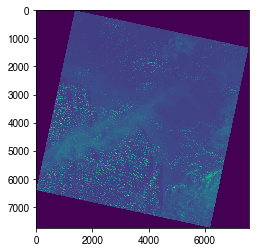

In [5]:
plt.imshow(L8_b2[0,:,:], origin='upper')

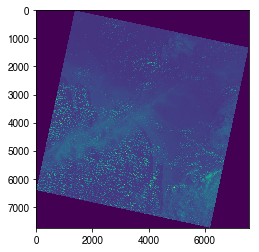

In [6]:
plt.imshow(L8_b3[0,:,:], origin='upper')

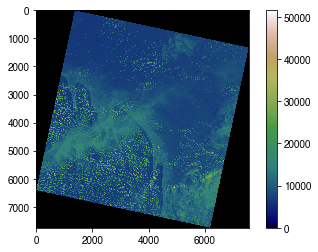

In [7]:
plt.imshow(L8_b4[0,:,:], origin='upper', cmap='gist_earth')
plt.colorbar()

# Also merge the RGB channels into one array, plot "true color" image

Adapted from here:  
https://colekrehbiel.wordpress.com/2017/10/01/creating-natural-color-rgb-composites-from-landsat-8-data-in-python/

In [8]:
def norm(band):
    band[band<0]=0
    band[band>20000]=20000
    band_min, band_max = 0, 20000
    return ((band - band_min)/(band_max - band_min))

In [9]:
L8_b2_norm = norm(L8_b2[0,:,:].values)
L8_b3_norm = norm(L8_b3[0,:,:].values)
L8_b4_norm = norm(L8_b4[0,:,:].values)

In [10]:
L8_rgb_432 = np.dstack((L8_b4_norm, L8_b3_norm, L8_b2_norm))

`imshow()` can take either a 2D image with values **or** a 3D array where the third dimension has RGB values:

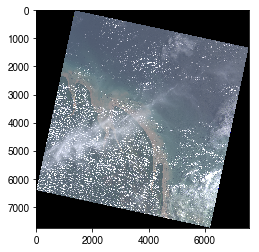

In [11]:
plt.imshow(L8_rgb_432)

# (3) Use the projection metadata to communicate where this tile is in geographic space

Do this with the transform info from the opened GeoTIFF data array.  All channels have the same info, so let's just use channel 2 for the task.  
Call this boundary information `data_extent`:

In [12]:
data_extent = (L8_b2.transform[0], \
               L8_b2.transform[0] + L8_b2.x.size*L8_b2.transform[1], \
               L8_b2.transform[3] + L8_b2.y.size*L8_b2.transform[5], \
               L8_b2.transform[3])

Use `data_extent` within the `imshow` command to communicate where in geographical space the tile is.  
Also use the `cartopy.crs.epsg(32622)` to create a map projection using the original data:  

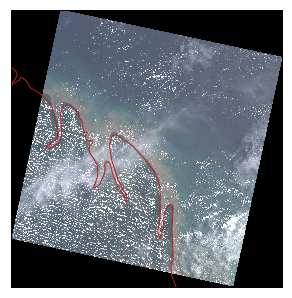

In [13]:
map_crs = cartopy.crs.epsg(32622)
data_crs = cartopy.crs.epsg(32622)

fig = plt.figure(figsize=(4.25,4.25))
ax = fig.add_subplot(111, projection=map_crs)
image = ax.imshow(L8_rgb_432, extent=(data_extent[0],data_extent[1],data_extent[2],data_extent[3]), \
                  origin='upper', transform=data_crs)
ax.coastlines(resolution='10m', color='firebrick')

fig.tight_layout()
fig.savefig('../figures/5-landsat-true-color.pdf', bbox_inches='tight', transparent=True)